# Optimizing 2D GeoLIPI programs
Since GeoLIPI programs are parameterized using pyTorch, we can optimize them with pytorch's auto-grad and gradient based optimizers 

In [1]:
# 1.1 2D CSG
import os
import numpy as np
import torch as th
import geolipi.symbolic as gls
import cv2
from geolipi.torch_compute import expr_to_sdf, recursive_evaluate
from geolipi.torch_compute import Sketcher
from geolipi.torch_compute.evaluate_expression import smoothen_sdf
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
resolution = 256
sketcher_2d = Sketcher(resolution=resolution, n_dims=2)

(256, 256)


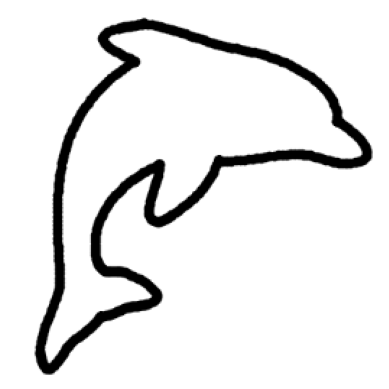

In [3]:
# DeepSVG example of line Opt - without correspondence/SVG GT.
# load target
target = cv2.imread("../assets/dolphin_points.png", cv2.IMREAD_GRAYSCALE)
# show target
target = target[60:-60, 140:-140]
# Rescale to 256
target = cv2.resize(target, (resolution, resolution))
print(target.shape)
plt.imshow(target, cmap='gray')
plt.axis('off')
target_occ = target < 255
target_occ = th.tensor(target_occ, dtype=th.float32, device="cuda").reshape(-1)


(-0.5, 255.5, 255.5, -0.5)

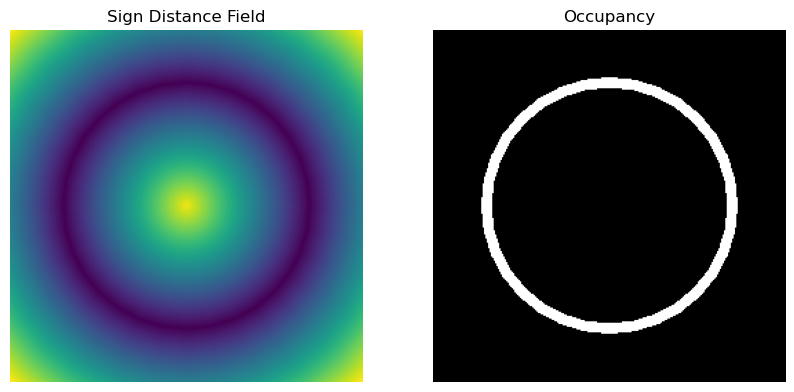

In [4]:
# Now generate expression 
# Line approx
def get_circle_points(radius=0.1, n_points=100, angle_delta=0.0):
    n_points = n_points + 1
    angles = np.linspace(0, 2*np.pi, n_points) + angle_delta
    points = np.zeros((n_points, 2))
    points[:, 0] = radius * np.cos(angles)
    points[:, 1] = radius * np.sin(angles)
    return points
# sample points
n_points = 32
points = get_circle_points(0.7, n_points)
tensor_points = th.tensor(points, device="cuda", dtype=th.float32, requires_grad=True)
subexpr = []
for i in range(n_points):
    expr = gls.Segment2D(tensor_points[i], tensor_points[(i+1)%n_points])
    subexpr.append(expr)
dil_tensor = th.tensor([0.03,], device="cuda")
expr = gls.Dilate2D(gls.Union(*subexpr), dil_tensor)

# show the output
# print(expr.pretty_print())
sdf = recursive_evaluate(expr, sketcher_2d)
# target_occ = (sdf <= 0.00).float()
sdf = sdf.reshape(resolution, resolution).detach().cpu().numpy()
occ = (sdf <= 0.00)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sdf)
plt.axis('off')
plt.title("Sign Distance Field")
plt.subplot(1, 2, 2)
plt.imshow(occ, cmap='gray')
plt.title("Occupancy")
plt.axis('off')

In [ ]:
# Now the optimization loop:
optim = th.optim.Adam([tensor_points], lr=0.005)
n_iters  = 2048
# The amount of "smoothing"
t_vals = np.linspace(2, 15, n_iters)

for i in range(n_iters):
# for i in range(200):
    optim.zero_grad()
    # unpack tensor_points
    # creating the list of tensors in inject into expression
    tensor_list = []
    for ind in range(n_points):
        tensor_list.append(tensor_points[ind])
        tensor_list.append(tensor_points[(ind + 1) % n_points])
    tensor_list.append(dil_tensor)
    cur_expr = expr.inject_tensor_list(tensor_list)
    sdf = recursive_evaluate(cur_expr, sketcher_2d)
    soft_sdf = smoothen_sdf(sdf, t_vals[i])
    loss = 0.5 * th.sum(((soft_sdf - target_occ)) ** 2)
    loss.backward()
    optim.step()
    if i % 200 == 0:
        print(f"SDF Loss: {loss.item()}, iter: {i}")
    
    

In [ ]:
sdf = recursive_evaluate(cur_expr, sketcher_2d)
soft_sdf = smoothen_sdf(sdf, t_vals[i])
soft_sdf = soft_sdf.reshape(resolution, resolution).detach().cpu().numpy()
sdf = sdf.reshape(resolution, resolution).detach().cpu().numpy()
occ = (sdf <= 0.00)
target = target_occ.reshape(resolution, resolution).detach().cpu().numpy()
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(sdf)
plt.axis('off')
plt.title("Sign Distance Field")
plt.subplot(1, 4, 2)
plt.imshow(soft_sdf,)
plt.title("Soft SDF")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(occ, cmap='gray')
plt.title("Optimized Occupancy")
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(target, cmap='gray')
plt.title("Target")
plt.axis('off')


In [ ]:
# Now generate expression 
# sample points
n_points = 32
points = get_circle_points(0.7, n_points)
mid_points = get_circle_points(0.7, n_points, angle_delta=np.pi/n_points)
tensor_points = th.tensor(points, device="cuda", dtype=th.float32, requires_grad=True)
tensor_mid_points = th.tensor(mid_points, device="cuda", dtype=th.float32, requires_grad=True)
subexpr = []
for i in range(n_points):
    expr = gls.QuadraticBezierCurve2D(tensor_points[i], tensor_mid_points[i], tensor_points[(i+1)%n_points])
    subexpr.append(expr)
dil_tensor = th.tensor([0.2,], device="cuda")
expr = gls.Dilate2D(gls.Union(*subexpr), dil_tensor)

# show the output
# print(expr.pretty_print())
sdf = recursive_evaluate(expr, sketcher_2d)
# target_occ = (sdf <= 0.00).float()
sdf = sdf.reshape(resolution, resolution).detach().cpu().numpy()
occ = (sdf <= 0.00)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sdf)
plt.axis('off')
plt.title("Sign Distance Field")
plt.subplot(1, 2, 2)
plt.imshow(occ, cmap='gray')
plt.title("Occupancy")
plt.axis('off')

In [ ]:

DISP_THRESHOLD = 0.1
def compute_point_overlap_loss(all_points):
    all_points = tensor_points
    n_p = all_points.shape[0]
    all_points_a = all_points[:, None, :].expand(n_p, n_p, 2)
    all_points_b = all_points[None, :, :].expand(n_p, n_p, 2)
    all_points_dist = th.norm(all_points_a - all_points_b, dim=-1)
    cur_loss = th.where(all_points_dist > DISP_THRESHOLD, th.zeros_like(all_points_dist), all_points_dist)
    cur_loss = th.sum(cur_loss)
    one_shifted = th.roll(all_points, 1, 0)
    two_shifted = th.roll(all_points, 2, 0)
    ab = one_shifted - all_points
    bc = two_shifted - one_shifted
    return cur_loss

In [ ]:
def generate_plt_figure(cur_expr, sketcher_2d, cur_t_val, resolution):
    sdf = recursive_evaluate(cur_expr, sketcher_2d)
    occ = (sdf.clone() <= 0.00)
    soft_sdf = smoothen_sdf(sdf.clone(), cur_t_val)
    sdf = sdf.reshape(resolution, resolution).detach().cpu().numpy()
    soft_sdf = soft_sdf.reshape(resolution, resolution).detach().cpu().numpy()
    target = target_occ.reshape(resolution, resolution).detach().cpu().numpy()
    occ = occ.reshape(resolution, resolution).detach().cpu().numpy()
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(sdf)
    plt.axis('off')
    plt.title("Sign Distance Field")
    plt.subplot(1, 4, 2)
    plt.imshow(soft_sdf,)
    plt.title("Soft Occupancy")
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(occ, cmap='gray')
    plt.title("Execution")
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(target, cmap='gray')
    plt.title("Target")
    plt.axis('off')

In [ ]:
# Now the optimization loop:

optim = th.optim.Adam([tensor_points, tensor_mid_points], lr=0.005)
n_iters  = 2048
point_spread_loss_wt = 1.0
# The amount of "smoothing"
t_vals = np.linspace(2, 12, n_iters)

for i in range(n_iters):
    optim.zero_grad()
    # unpack tensor_points
    # creating the list of tensors
    tensor_list = []
    for ind in range(n_points):
        tensor_list.append(tensor_points[ind])
        tensor_list.append(tensor_mid_points[ind])
        tensor_list.append(tensor_points[(ind+1)%n_points])
    tensor_list.append(dil_tensor)
    cur_expr = expr.inject_tensor_list(tensor_list)
    sdf = recursive_evaluate(cur_expr, sketcher_2d)
    cur_t_val = t_vals[i]
    soft_sdf = smoothen_sdf(sdf, cur_t_val)
    sdf_diff = ((soft_sdf - target_occ)) ** 2
    sdf_loss = 0.5 * th.sum(sdf_diff)
    # Add a loss for lines endpoints not overlapping to 0?
    point_overlap_loss = compute_point_overlap_loss(tensor_points)
    loss = point_overlap_loss * point_spread_loss_wt + sdf_loss
    loss.backward()
    optim.step()
    # generate_plt_figure(cur_expr, sketcher_2d, cur_t_val, resolution)
    # file_name = os.path.join(f'temp/{i}.png')
    # plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()
    if i % 200 == 0:
        print(f"SDF Loss: {sdf_loss.item()}, Point_loss: {point_overlap_loss.item()}, iter: {i}")
    
    

In [ ]:
generate_plt_figure(cur_expr, sketcher_2d, cur_t_val, resolution)
plt.savefig("../assets/svg_optimization.png", bbox_inches='tight', pad_inches=0)

In [ ]:
# Convert to gif
import imageio
file_names = [os.path.join(f'temp/{i}.png') for i in range(n_iters)]
file_names = file_names[:1024]

images = [imageio.imread(fn) for fn in file_names]
imageio.mimsave('../assets/svg_path_opt.gif', images, fps=32)


In [4]:
resolution = 256
sketcher_2d = Sketcher(resolution=resolution, n_dims=2)

(2250, 2267, 4)


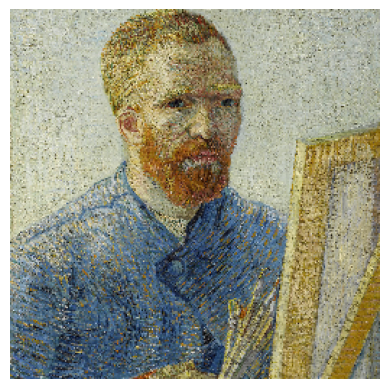

In [6]:
# Example 2: Simple SVG
# from geolipi.torch_compute import expr_to_colored_canvas
# load target:
target = cv2.imread("../assets/van_gogh.jpg")
# Convert to RGBA
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGBA)
# show target
target = target[150:-550]
print(target.shape)
target = cv2.resize(target, (resolution, resolution))
plt.imshow(target)
plt.axis('off')
target = th.tensor(target, dtype=th.float32, device="cuda").reshape(-1, 4)/255.0

In [7]:
def generate_plt_figure(cur_expr, sketcher_2d, cur_t_val, resolution):
    colored_canvas = recursive_evaluate(cur_expr, sketcher_2d)
    colored_canvas = colored_canvas.reshape(resolution, resolution, 4).detach().cpu().numpy()
    soft_canvas = recursive_evaluate(cur_expr, sketcher_2d, 
                                        relaxed_occupancy=True,
                                        relax_temperature= cur_t_val)
    soft_canvas = soft_canvas.reshape(resolution, resolution, 4).detach().cpu().numpy()
    target_disp = target.reshape(resolution, resolution, 4).detach().cpu().numpy()
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(soft_canvas)
    plt.axis('off')
    plt.title("Soft Execution")
    plt.subplot(1, 3, 2)
    plt.imshow(colored_canvas)
    plt.axis('off')
    plt.title("Optimized Execution")
    plt.subplot(1, 3, 3)
    plt.imshow(target_disp)
    plt.title("Target")
    plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

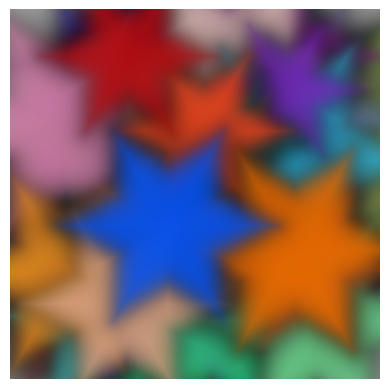

In [37]:

# Scatter a set of colored cubes and optimize their positions
# to match a target image.
n_rects = 64
rect_param = np.random.uniform(0.2, 0.4, size=(n_rects, 1))

rect_pos = np.random.uniform(-0.75, 0.75, size=(n_rects, 2))
rect_param = th.tensor(rect_param, device="cuda", dtype=th.float32, requires_grad=True)
rect_pos = th.tensor(rect_pos, device="cuda", dtype=th.float32, requires_grad=True)
colors = np.random.uniform(0.0, 1.0, size=(n_rects, 4))
colors[:, 3] = 0.95
colors_pre = np.arctanh(2 * colors - 1)
colors_pre = th.tensor(colors_pre, device="cuda", dtype=th.float32, requires_grad=True)
colors = (th.tanh(colors_pre) + 1) * 0.5
rect_list = []
for i in range(n_rects):
    rectangle = gls.ApplyColor2D(gls.Translate2D(gls.Hexagram2D(rect_param[i]), rect_pos[i]), colors[i])
    rect_list.append(rectangle)
expr = gls.SourceOverSequence(*rect_list)
# show the output
colored_canvas = recursive_evaluate(expr, sketcher_2d, 
                                    relaxed_occupancy=True,
                                    relax_temperature= 5.0,)
colored_canvas = colored_canvas.reshape(resolution, resolution, 4).detach().cpu().numpy()
plt.imshow(colored_canvas)
plt.axis('off')

In [38]:
# Now the optimization loop:

optim = th.optim.Adam([rect_param, rect_pos, colors_pre], lr=0.005)
n_iters  = 2048
point_spread_loss_wt = 1.0
# The amount of "smoothing"
t_vals = np.linspace(np.log(np.log(4)), np.log(np.log(15)), n_iters)
t_vals = np.exp((np.exp(t_vals)))
alpha_range = np.linspace(0, 10, n_iters)
alpha_range = alpha_range/100.0


for i in range(n_iters):
# for i in range(200):
    optim.zero_grad()
    # unpack tensor_points
    # creating the list of tensors
    tensor_list = []
    colors = (th.tanh(colors_pre) + 1)
    colors[:, :-1] = colors[:, :-1] * 0.5
    colors[:, -1] = colors[:, -1] * (0.40 + alpha_range[i])

    # t_ps = th.tanh(primal_points)
    for ind in range(n_rects):
        tensor_list.append(rect_param[ind])
        tensor_list.append(rect_pos[ind])
        tensor_list.append(colors[ind])
    cur_expr = expr.inject_tensor_list(tensor_list)
    cur_t_val = t_vals[i]
    color_out = recursive_evaluate(cur_expr, sketcher_2d, 
                                    relaxed_occupancy=True,
                                    relax_temperature= cur_t_val,)
    color_diff = color_out - target
    color_diff = th.norm(color_diff, dim=-1)
    # Drop points stochastically
    # point_overlap_loss = compute_point_overlap_loss(rect_pos)
    # color_diff = th.nn.functional.dropout(color_diff, p=0.1, training=True)
    color_loss = 0.5 * th.sum(color_diff)
    ret_origin_dist = rect_pos.norm(dim=-1)
    rect_pos_loss = th.sum(th.where(ret_origin_dist > 0.8, ret_origin_dist, th.zeros_like(ret_origin_dist)))
    rect_sizes = rect_param[:, 0] #* rect_param[:, 1]
    rect_size_loss = th.sum(th.where(rect_sizes < 0.25, -rect_sizes, th.zeros_like(rect_sizes)))
    rect_size_loss_2 = th.sum(th.where(rect_sizes > .75, rect_sizes, th.zeros_like(rect_sizes)))

    # Add a loss for lines endpoints not overlapping to 0?
    # point_overlap_loss = compute_point_overlap_loss(tensor_points)
    loss = color_loss  #+ 5000 * (rect_pos_loss + rect_size_loss + rect_size_loss_2)# + point_overlap_loss * point_spread_loss_wt
    loss.backward()
    # colors.grad[:, -1] = 0
    generate_plt_figure(cur_expr, sketcher_2d, cur_t_val, resolution)
    file_name = os.path.join(f'temp/{i}.png')
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    plt.close()
    optim.step()
    if i % 25 == 0:
        print(f"Color Loss: {color_loss.item()}, pos_loss: {rect_pos_loss.item()}, size_loss: {rect_size_loss.item()}, iter: {i}")
    
    

Color Loss: 14008.7509765625, pos_loss: 6.014261722564697, size_loss: -3.214071273803711, iter: 0
Color Loss: 9452.931640625, pos_loss: 12.85041332244873, size_loss: -3.570894241333008, iter: 25
Color Loss: 7841.3193359375, pos_loss: 17.79005241394043, size_loss: -3.785721778869629, iter: 50
Color Loss: 7072.73193359375, pos_loss: 20.73746109008789, size_loss: -2.9297733306884766, iter: 75
Color Loss: 6751.30517578125, pos_loss: 20.390592575073242, size_loss: -2.909717559814453, iter: 100
Color Loss: 6546.484375, pos_loss: 20.56266212463379, size_loss: -2.926179885864258, iter: 125
Color Loss: 6415.69873046875, pos_loss: 22.251556396484375, size_loss: -2.7499613761901855, iter: 150
Color Loss: 6318.484375, pos_loss: 23.037757873535156, size_loss: -3.1020607948303223, iter: 175
Color Loss: 6243.00244140625, pos_loss: 23.056076049804688, size_loss: -3.1479177474975586, iter: 200
Color Loss: 6180.70458984375, pos_loss: 22.285953521728516, size_loss: -3.3035569190979004, iter: 225
Color Lo

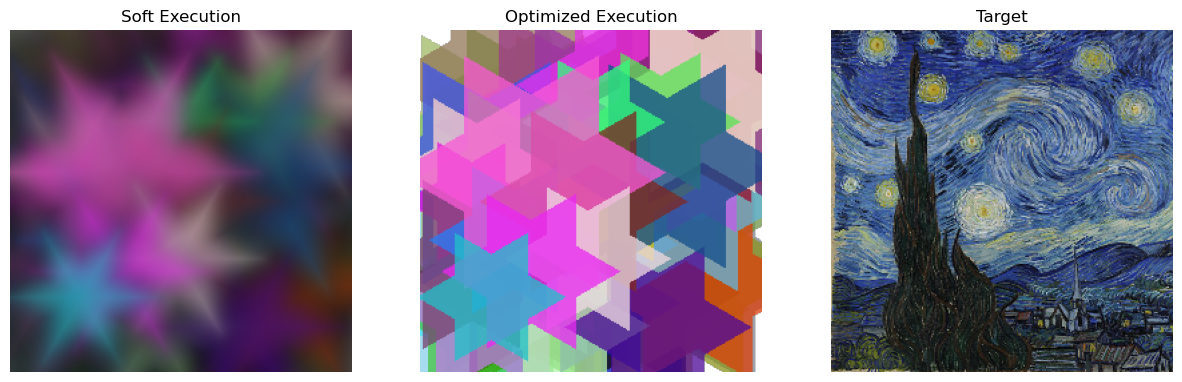

In [ ]:
generate_plt_figure(cur_expr, sketcher_2d, cur_t_val, resolution)
plt.savefig("../assets/starry.png", bbox_inches='tight', pad_inches=0)

In [8]:
# Convert to gif
import imageio
n_iters = 2048
file_names = [os.path.join(f'temp/{i}.png') for i in range(n_iters)]
file_names = [x for ind, x in enumerate(file_names) if ind %4 ==0]

images = [imageio.imread(fn) for fn in file_names]
imageio.mimsave('../assets/starry.gif', images, fps=64)


/tmp/ipykernel_2440210/1194114890.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fn) for fn in file_names]


# TODO: Layer-wise optimization - LIVE style

(599, 600, 4)


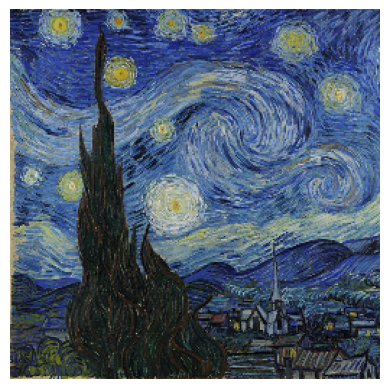

In [6]:
# 128 circles for starry night
# from geolipi.torch_compute import expr_to_colored_canvas
# load target:
target = cv2.imread("../assets/Starry_Night.jpg")
# Convert to RGBA
target = cv2.cvtColor(target, cv2.COLOR_BGR2RGBA)
# show target
target = target[:,0:-157]
print(target.shape)
resolution = 256
target = cv2.resize(target, (resolution, resolution))
plt.imshow(target)
plt.axis('off')
target = th.tensor(target, dtype=th.float32, device="cuda").reshape(-1, 4)/255.0

In [ ]:
n_prim_per_layer = 64
n_layers = 1
lr = 0.005
n_iters = 2000
t_min = 4
t_max = 15
TAU = 0.1

t_vals = np.linspace(np.log(np.log(4)), np.log(np.log(15)), n_iters)
t_vals = np.exp((np.exp(t_vals)))
alpha_range = np.linspace(0, 10, n_iters)
alpha_range = alpha_range/100.0

In [ ]:
# Example 3: SVG with UDF + Layerwise optimization

# 1 loss is driven by sdf.

# Scatter a set of colored cubes and optimize their positions
# to match a target image.
def generate_random_circles(n_circles):

    circle_param = np.random.uniform(0.2, 0.5, size=(n_rects, 1))
    circle_pos = np.random.uniform(-0.75, 0.75, size=(n_rects, 2))
    circle_scale = np.random.uniform(0.25, 1.75, size=(n_rects, 2))

    circle_param = th.tensor(circle_param, device="cuda", dtype=th.float32, requires_grad=True)
    circle_pos = th.tensor(circle_pos, device="cuda", dtype=th.float32, requires_grad=True)
    circle_scale = th.tensor(circle_scale, device="cuda", dtype=th.float32, requires_grad=True)

    colors = np.random.uniform(0.0, 1.0, size=(n_rects, 4))
    colors[:, 3] = 0.95
    colors_pre = np.arctanh(2 * colors - 1)
    colors_pre = th.tensor(colors_pre, device="cuda", dtype=th.float32, requires_grad=True)
    colors = (th.tanh(colors_pre) + 1) * 0.5
    
    onion_pt = th.tensor([0.1,], dtype=th.float32, device="cuda")

    colored_circle_list = []
    circle_list= []
    for i in range(n_circles):
        colored_circle = gls.ApplyColor2D(
            gls.Translate2D(
                gls.Scale2D(
                    gls.Circle2D(circle_param[i]),
                    circle_scale[i]),
                circle_pos[i]), 
            colors[i])
        colored_circle_list.append(colored_circle)
        circle = gls.Translate2D(
                gls.Scale2D(
                    gls.Circle2D(circle_param[i]),
                    circle_scale[i]),
                circle_pos[i])
        circle = gls.Onion2D(circle, onion_pt)
        circle_list.append(circle)
    param_list = [circle_param, circle_scale, circle_pos, colors_pre]
    return colored_circle_list, circle_list, param_list




In [ ]:

# Scatter a set of colored cubes and optimize their positions
# to match a target image.
all_circles = []
all_colored_circles = []

onion_pt = th.tensor([0.1,], dtype=th.float32, device="cuda")
param_list = []
for cur_layer in range(n_layers):
    new_colored_circles, new_circles, new_params = generate_random_circles(n_prim_per_layer)
    all_circles.extend(new_circles)
    all_colored_circles.extend(new_colored_circles)
    if not param_list:
        param_list = new_params
    else:
        for ind, param in enumerate(param_list):
            param_list[ind] = th.tensor(param.detach().cpu().numpy(), device="cuda", dtype=th.float32, requires_grad=False)
        param_list.extend(new_params)
    colored_expr = gls.SourceOverSequence(*all_colored_circles)
    sdf_expr = gls.Union(*all_circles)
    # break
    saturated = False
    optim = th.optim.Adam(param_list[-4:], lr=lr)
    while(not saturated):
        # TODO: Make this elastic
        for i in range(n_iters):
        # for i in range(200):
            optim.zero_grad()
            # unpack tensor_points
            # creating the list of tensors
            tensor_list = []
            colors_pre = param_list[-1]
            colors = (th.tanh(colors_pre) + 1)
            colors[:, :-1] = colors[:, :-1] * 0.5
            colors[:, -1] = colors[:, -1] * (0.40 + alpha_range[i])

            # t_ps = th.tanh(primal_points)
            tensor_list = colored_expr.gather_tensor_list()
            limit = 4 * n_prim_per_layer * (cur_layer)
            tensor_list = tensor_list[:limit]
            tensor_list = [x.detach() for x in tensor_list]
            for ind in range(n_prim_per_layer):
                tensor_list.append(param_list[-4][ind])
                tensor_list.append(param_list[-3][ind])
                tensor_list.append(param_list[-2][ind])
                tensor_list.append(colors[ind])
            cur_color_expr = colored_expr.inject_tensor_list(tensor_list)
            cur_t_val = t_vals[i]
            color_out = recursive_evaluate(cur_color_expr, sketcher_2d, 
                                            relaxed_occupancy=True,
                                            relax_temperature= cur_t_val,)
            color_diff = color_out - target
            color_diff = th.norm(color_diff, dim=-1)
            # Now this should be summed with sdf loss

            tensor_list = sdf_expr.gather_tensor_list()
            limit = 4 * n_prim_per_layer * (cur_layer)
            tensor_list = [x.detach() for x in tensor_list[:limit]]
            for ind in range(n_prim_per_layer):
                tensor_list.append(param_list[-4][ind])
                tensor_list.append(param_list[-3][ind])
                tensor_list.append(param_list[-2][ind])
                tensor_list.append(onion_pt)
            cur_expr = sdf_expr.inject_tensor_list(tensor_list)
            sdf_out = expr_to_sdf(cur_expr, sketcher_2d)
            # print(sdf_out.min(), sdf_out.max())
            # dist_weight = th.logical_and(-0.1<=sdf_out, sdf_out <=0).float()
            dist_weight = (sdf_out <=0).float()
            # dist_weight = th.nn.functional.relu(TAU - th.abs(sdf_out))
            dist_weight = dist_weight# /(dist_weight.sum() + 1e-4)
            dist_weight = dist_weight.detach()
            # Drop points stochastically
            # point_overlap_loss = compute_point_overlap_loss(rect_pos)
            # color_diff = th.nn.functional.dropout(color_diff, p=0.1, training=True)
            color_loss = th.sum(color_diff * dist_weight)
            # color_loss = th.sum(color_diff)
            # Add a loss for lines endpoints not overlapping to 0?
            # point_overlap_loss = compute_point_overlap_loss(tensor_points)
            loss = color_loss # + point_overlap_loss * point_spread_loss_wt
            loss.backward()
            # colors.grad[:, -1] = 0
            optim.step()
            if i % 50 == 0:
                print(f"Color Loss: {color_loss.item()}, iter: {i}")
        saturated = True
    
    


In [ ]:

colored_canvas = recursive_evaluate(cur_color_expr, sketcher_2d)
colored_canvas = colored_canvas.reshape(resolution, resolution, 4).detach().cpu().numpy()
sdf = recursive_evaluate(cur_expr, sketcher_2d)
sdf = sdf.reshape(resolution, resolution).detach().cpu().numpy()
target_disp = target.reshape(resolution, resolution, 4).detach().cpu().numpy()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(colored_canvas)
plt.axis('off')
plt.title("Optimized Execution")
plt.subplot(1, 3, 2)
plt.imshow(sdf)
plt.axis('off')
plt.title("Optimized SDF")
plt.subplot(1, 3, 3)
plt.imshow(target_disp)
plt.title("Target")
plt.axis('off')

In [ ]:
# https://arxiv.org/pdf/2206.04655.pdf
# https://openaccess.thecvf.com/content/CVPR2023/papers/Jain_VectorFusion_Text-to-SVG_by_Abstracting_Pixel-Based_Diffusion_Models_CVPR_2023_paper.pdf
# Initialization
# UDF Loss and Xing Loss
# Updates.
